In [11]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

from src.models.train_model import train_svm
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToFeatures
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.features.descriptors import HOGDescriptor, LBPDescriptor
from src.models.classifiers import ProbSVMModelWrapper
from src.evaluation import validate_model, precision, recall, f1_score

# Aerial-Cars-Dataset
# SVM Experiment

### Data loading

In [2]:
DATA_PATH = '../../../data/processed/aerial-cars-dataset/svm/data_svm.pickle'

In [3]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### SVM trainig

In [4]:
SAVE_MODEL_PATH = '../../../models/svm/aerial_svm.pickle'

In [4]:
model, report = train_svm(data, test_size=0.2, probability=True)

In [5]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       469
           1       0.98      0.99      0.99       475

    accuracy                           0.99       944
   macro avg       0.99      0.99      0.99       944
weighted avg       0.99      0.99      0.99       944



In [11]:
with open(SAVE_MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)

### Validation

In [5]:
with open(SAVE_MODEL_PATH, 'rb') as f:
    model = pickle.load(f)

In [8]:
BND_BOX_SIZE = (80, 80)

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline = RawImageToFeatures(
    processors=[],
    descriptors=[
        HOGDescriptor(
            orientations = 9,
            cells_per_block = (2, 2),
            pixels_per_cell = (4, 4),
            multichannel = True,
            visualize = True
        ),
        LBPDescriptor(
            bins = 256,
            range = (0, 256)
        )
    ]
)

sliding_window = SlidingWindow(
    step_size=20,
    window_size=BND_BOX_SIZE
)

#### treshold = 0.7; nms_overlap=0.4

In [12]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ProbSVMModelWrapper(model),
    treshold=0.7,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath='../../../data/raw/aerial-cars-dataset/val_dev',
    output_folder_filepath='../../processed_images/svm/aerial-cars-dataset',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=7
)

print()
print('Precision:',  precision(true_positives, false_positives))
print('Recall:',  recall(true_positives, false_negatives))
print('F1Score:', f1_score(true_positives, false_positives, false_negatives))

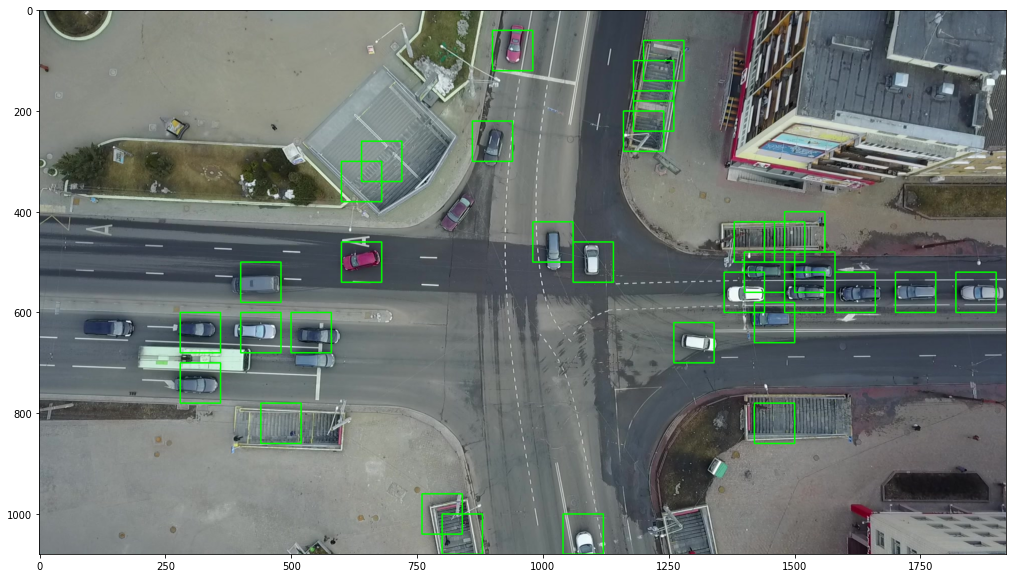

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])